In [348]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import TensorDataset, DataLoader
import joblib
import torch
import random
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import torch.optim as optim

from tqdm import tqdm
import numpy as np
df = pd.read_csv('/kaggle/input/newwyork/all_stocks_5yr.csv')
# Show the first 5 unique company names
unique_companies = df['Name'].unique()[:6]
print(unique_companies)
    
print("✅ Original Data:")
print(f"📐 Shape: {df.shape}")
print(f"🧾 Columns: {df.columns.tolist()}")
print("\n🔍 Sample Data:")
print(df.head())

# Drop rows with missing values (if any)
df = df.dropna()

# Convert and sort by date
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').reset_index(drop=True)

aal_df = df[df['Name'] == 'AAL'].copy()
aal_df.set_index('date', inplace=True)  # Set date as index for time-based operations
print(f"AAL Stock Data Shape: {aal_df.shape}")


# Select features and target
feature_cols = ['open', 'high', 'low', 'close', 'volume']
target_col = 'close'

features = aal_df[feature_cols].values.astype(np.float32)
target = aal_df[target_col].values.astype(np.float32)

# Normalize features and target separately
feature_scaler = StandardScaler()
target_scaler = StandardScaler()


scaled_features = feature_scaler.fit_transform(features)
scaled_target = target_scaler.fit_transform(target.reshape(-1, 1))
# Save the scaler for inference
joblib.dump(target_scaler, 'target_scaler.pkl')

# Print scaler stats (verify)
print(f"Original mean: ${target_scaler.mean_[0]:.2f}")
print(f"Original std: ${target_scaler.scale_[0]:.2f}")
# Create sequences with multiple features
def create_sequences(features, target, seq_length, pred_length):
    X, y = [], []
    for i in range(len(features) - seq_length - pred_length + 1):
        X.append(features[i:i+seq_length])  # Shape: (seq_length, num_features)
        y.append(target[i+seq_length:i+seq_length+pred_length])  # Shape: (pred_length,)
    return np.array(X), np.array(y)

SEQ_LENGTH = 10
PRED_LENGTH = 1

X, y = create_sequences(scaled_features, scaled_target, SEQ_LENGTH, PRED_LENGTH)
total_size = len(X)
train_size = int(0.7 * total_size)  # 60% training
val_size = int(0.15 * total_size)    # 20% validation
# test_size = total_size - train_size - val_size (remaining 20%)

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]

print(f"Dataset sizes:")
print(f"Training: {X_train.shape[0]} sequences")
print(f"Validation: {X_val.shape[0]} sequences")
print(f"Testing: {X_test.shape[0]} sequences")

X_train_tensor = torch.tensor(X_train).float()
y_train_tensor = torch.tensor(y_train).float()
X_val_tensor = torch.tensor(X_val).float()
y_val_tensor = torch.tensor(y_val).float()
X_test_tensor = torch.tensor(X_test).float()
y_test_tensor = torch.tensor(y_test).float()

# Create DataLoaders
batch_size = 16
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


for batch in train_loader:
    print(batch[0].shape)  # for a single tensor
    break

for batch in train_loader:
    print(batch[0].shape)  # for a single tensor
    break

['AAL' 'AAPL' 'AAP' 'ABBV' 'ABC' 'ABT']
✅ Original Data:
📐 Shape: (619040, 7)
🧾 Columns: ['date', 'open', 'high', 'low', 'close', 'volume', 'Name']

🔍 Sample Data:
         date   open   high    low  close    volume Name
0  2013-02-08  15.07  15.12  14.63  14.75   8407500  AAL
1  2013-02-11  14.89  15.01  14.26  14.46   8882000  AAL
2  2013-02-12  14.45  14.51  14.10  14.27   8126000  AAL
3  2013-02-13  14.30  14.94  14.25  14.66  10259500  AAL
4  2013-02-14  14.94  14.96  13.16  13.99  31879900  AAL
AAL Stock Data Shape: (1259, 6)
Original mean: $38.39
Original std: $10.95
Dataset sizes:
Training: 874 sequences
Validation: 187 sequences
Testing: 188 sequences
torch.Size([16, 10, 5])
torch.Size([16, 10, 5])


In [349]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Add_Norm(nn.Module):
    def __init__(self, d_model, dropout, residual=True):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.norm = nn.LayerNorm(d_model)
        self.residual = residual
    
    def forward(self, new, old):
        if self.residual:
            return self.norm(old + self.dropout(new))
        return self.norm(self.dropout(new))

class EncoderLayer(nn.Module):
    def __init__(self, d_model, nhead, d_ff, dropout=0.1, residual=True):
        super().__init__()
        # Attention blocks
        self.self_attn_forward = nn.MultiheadAttention(
            d_model, nhead, dropout=dropout, batch_first=True
        )
        
        # Normalization
        self.norm = nn.LayerNorm(d_model)
        
        # Add/Norm layers
        self.addnorm1 = Add_Norm(d_model, dropout, residual=False)
        self.addnorm2 = Add_Norm(d_model, dropout, residual=False)
        self.addnorm3 = Add_Norm(d_model, dropout, residual=residual)
        
        # Feed-forward network
        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, d_model)
        )
        self.addnorm4 = Add_Norm(d_model, dropout, residual=residual)

    def forward(self, x, mask=None):
        x_norm = self.norm(x)
        batch_size, seq_len, _ = x_norm.shape
        
        # Forward attention block
        attn_mask_forward = self._generate_square_subsequent_mask(seq_len).to(x.device)
        out, _ = self.self_attn_forward(
            x_norm, x_norm, x_norm, 
            attn_mask=attn_mask_forward,
            key_padding_mask=mask
        )
        out = self.addnorm1(out, x)
        
        # Feed-forward network
        ffn_out = self.ffn(out)
        return self.addnorm4(ffn_out, out)

    def _generate_square_subsequent_mask(self, sz):
        """Generate causal mask for attention"""
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

class Encoder(nn.Module):
    def __init__(self, input_features=5, d_model=64, n_layer=2, 
                 nhead=8, dropout=0.1, d_ff=512):
        super().__init__()
        # Input projection
        self.input_proj = nn.Linear(input_features, d_model)
        
        # Encoder layers
        self.layers = nn.ModuleList([
            EncoderLayer(
                d_model=d_model, 
                nhead=nhead,
                d_ff=d_ff,
                dropout=dropout
            ) for _ in range(n_layer)
        ])
        
        # Final layer norm
        self.final_norm = nn.LayerNorm(d_model)
        self._init_weights()

    def _init_weights(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, x, mask=None):
        x = self.input_proj(x)
        for layer in self.layers:
            x = layer(x, mask=mask)
        return self.final_norm(x)

In [350]:
import torch
import torch.nn as nn
import math

class DecoderLayer(nn.Module):
    def __init__(
        self,
        d_model,
        n_heads, 
        dropout,
        d_ff,
        activation="relu"
    ):
        super().__init__()
        
        # Self-attention layer with causal masking
        self.self_attn = nn.MultiheadAttention(
            embed_dim=d_model,
            num_heads=n_heads,
            dropout=dropout,
            batch_first=True
        )
        self.norm1 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        
        # Cross-attention layer
        self.cross_attn = nn.MultiheadAttention(
            embed_dim=d_model,
            num_heads=n_heads,
            dropout=dropout,
            batch_first=True
        )
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout2 = nn.Dropout(dropout)
        
        # Feed-forward network
        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, d_model)
        )
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout3 = nn.Dropout(dropout)

    def forward(self, target, encoder_output, src_mask=None, tgt_mask=None):
        # 1. Self-attention block (causal)
        residual = target
        target = self.norm1(target)
        
        # Create causal mask if not provided
        if tgt_mask is None:
            tgt_mask = self._generate_causal_mask(target.size(1)).to(target.device)
            
        self_attn_out, _ = self.self_attn(
            query=target,
            key=target,
            value=target,
            attn_mask=tgt_mask,
            need_weights=False
        )
        target = residual + self.dropout1(self_attn_out)
        
        # 2. Cross-attention block
        residual = target
        target = self.norm2(target)
        cross_attn_out, attn_weights = self.cross_attn(
            query=target,
            key=encoder_output,
            value=encoder_output,
            key_padding_mask=src_mask  # True = ignore/mask
        )
        target = residual + self.dropout2(cross_attn_out)
        
        # 3. FFN block
        residual = target
        target = self.norm3(target)
        target = residual + self.dropout3(self.ffn(target))
        
        return target, attn_weights

    def _generate_causal_mask(self, sz):
        """Generate causal mask for decoder self-attention"""
        mask = torch.triu(torch.ones(sz, sz), diagonal=1)
        mask = mask.masked_fill(mask == 1, float('-inf'))
        return mask


class Decoder(nn.Module):
    def __init__(self,
                 d_model=64,
                 n_heads=4,
                 n_layer=2,
                 dropout=0.1,
                 d_ff=256,
                 input_dim=1,
                 output_dim=1,
                 pred_length=30):  # Prediction length
        super().__init__()
        self.pred_length = pred_length
        
        # Input projection
        self.input_proj = nn.Linear(input_dim, d_model)
        
        # Positional encoding
        self.pos_encoder = PositionalEncoding(d_model)
        
        # Decoder layers
        self.layers = nn.ModuleList([
            DecoderLayer(
                d_model=d_model,
                n_heads=n_heads,
                dropout=dropout,
                d_ff=d_ff,
                activation="relu"
            ) for _ in range(n_layer)
        ])
        
        # Output projection
        self.output_proj = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, output_dim)
        )
        
        self._init_weights()

    def _init_weights(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, target, encoder_output, tgt_mask=None, src_mask=None):
        # Project input and add positional encoding
        x = self.input_proj(target)
        x = self.pos_encoder(x)
        
        # Apply padding mask if provided
        if tgt_mask is not None:
            x = x.masked_fill(tgt_mask.unsqueeze(-1), 0.0)
            
        # Process through decoder layers
        attn_weights = []
        for layer in self.layers:
            x, attn = layer(
                x, 
                encoder_output, 
                src_mask=src_mask,
                tgt_mask=tgt_mask
            )
            attn_weights.append(attn)
        
        # Output projection
        predictions = self.output_proj(x)
        
        # Return predictions and attention weights
        return predictions.squeeze(-1), attn_weights

# Positional Encoding Class (needed for decoder)
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=0.1)
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(1, max_len, d_model)
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

Epoch 1/20: 100%|██████████| 12/12 [00:00<00:00, 149.97it/s]


Epoch 1: Train Loss=0.1632, Val Loss=0.0448, Val RMSE=0.3001
-> Saved Best Model


Epoch 2/20: 100%|██████████| 12/12 [00:00<00:00, 154.37it/s]


Epoch 2: Train Loss=0.0937, Val Loss=0.0471, Val RMSE=0.3106


Epoch 3/20: 100%|██████████| 12/12 [00:00<00:00, 139.10it/s]


Epoch 3: Train Loss=0.0527, Val Loss=0.0254, Val RMSE=0.2286
-> Saved Best Model


Epoch 4/20: 100%|██████████| 12/12 [00:00<00:00, 145.21it/s]


Epoch 4: Train Loss=0.0594, Val Loss=0.0285, Val RMSE=0.2411


Epoch 5/20: 100%|██████████| 12/12 [00:00<00:00, 141.99it/s]


Epoch 5: Train Loss=0.0538, Val Loss=0.0376, Val RMSE=0.2737


Epoch 6/20: 100%|██████████| 12/12 [00:00<00:00, 152.57it/s]


Epoch 6: Train Loss=0.0347, Val Loss=0.0209, Val RMSE=0.2054
-> Saved Best Model


Epoch 7/20: 100%|██████████| 12/12 [00:00<00:00, 148.67it/s]


Epoch 7: Train Loss=0.0347, Val Loss=0.0135, Val RMSE=0.1647
-> Saved Best Model


Epoch 8/20: 100%|██████████| 12/12 [00:00<00:00, 153.76it/s]


Epoch 8: Train Loss=0.0390, Val Loss=0.0334, Val RMSE=0.2583


Epoch 9/20: 100%|██████████| 12/12 [00:00<00:00, 140.38it/s]


Epoch 9: Train Loss=0.0346, Val Loss=0.0140, Val RMSE=0.1680


Epoch 10/20: 100%|██████████| 12/12 [00:00<00:00, 146.80it/s]


Epoch 10: Train Loss=0.0210, Val Loss=0.0152, Val RMSE=0.1744


Epoch 11/20: 100%|██████████| 12/12 [00:00<00:00, 149.48it/s]


Epoch 11: Train Loss=0.0221, Val Loss=0.0105, Val RMSE=0.1445
-> Saved Best Model


Epoch 12/20: 100%|██████████| 12/12 [00:00<00:00, 148.53it/s]


Epoch 12: Train Loss=0.0185, Val Loss=0.0135, Val RMSE=0.1638


Epoch 13/20: 100%|██████████| 12/12 [00:00<00:00, 148.10it/s]


Epoch 13: Train Loss=0.0194, Val Loss=0.0347, Val RMSE=0.2627


Epoch 14/20: 100%|██████████| 12/12 [00:00<00:00, 141.36it/s]


Epoch 14: Train Loss=0.0177, Val Loss=0.0337, Val RMSE=0.2622


Epoch 15/20: 100%|██████████| 12/12 [00:00<00:00, 153.25it/s]


Epoch 15: Train Loss=0.0242, Val Loss=0.0068, Val RMSE=0.1161
-> Saved Best Model


Epoch 16/20: 100%|██████████| 12/12 [00:00<00:00, 150.64it/s]


Epoch 16: Train Loss=0.0158, Val Loss=0.0091, Val RMSE=0.1339


Epoch 17/20: 100%|██████████| 12/12 [00:00<00:00, 153.27it/s]


Epoch 17: Train Loss=0.0160, Val Loss=0.0087, Val RMSE=0.1313


Epoch 18/20: 100%|██████████| 12/12 [00:00<00:00, 145.43it/s]


Epoch 18: Train Loss=0.0160, Val Loss=0.0110, Val RMSE=0.1474


Epoch 19/20: 100%|██████████| 12/12 [00:00<00:00, 149.68it/s]


Epoch 19: Train Loss=0.0128, Val Loss=0.0091, Val RMSE=0.1333


Epoch 20/20: 100%|██████████| 12/12 [00:00<00:00, 151.30it/s]


Epoch 20: Train Loss=0.0108, Val Loss=0.0081, Val RMSE=0.1249

Early stopping triggered at epoch 20


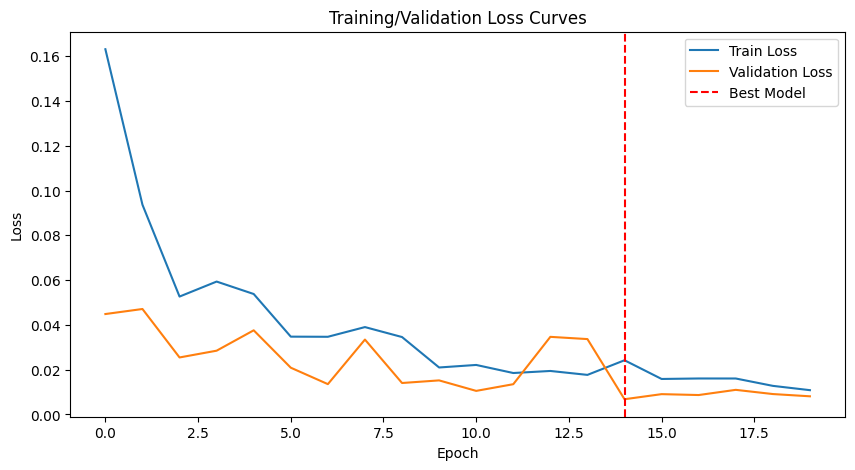

In [351]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import numpy as np
from sklearn.metrics import mean_squared_error
import random
import matplotlib.pyplot as plt

# Fix seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
set_seed()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Enhanced Loss Function
class StockLoss(nn.Module):
    def __init__(self, delta=0.5, direction_weight=0.6, margin=0.02):
        super().__init__()
        self.huber = nn.HuberLoss(delta=delta)
        self.direction_weight = direction_weight
        self.margin = margin
        
    def forward(self, preds, targets):
        # Base regression loss
        huber_loss = self.huber(preds, targets)
        
        # Directional loss only for multi-step predictions
        if preds.size(1) > 1:
            pred_dirs = preds[:, 1:] - preds[:, :-1]
            true_dirs = targets[:, 1:] - targets[:, :-1]
            
            # Only consider significant movements
            significant_moves = (true_dirs.abs() > self.margin).float()
            dir_accuracy = torch.sign(pred_dirs * true_dirs)
            
            # Loss for wrong directions on significant moves
            dir_loss = torch.mean(torch.relu(-dir_accuracy * significant_moves))
        else:
            dir_loss = torch.tensor(0.0, device=preds.device)
            
        return huber_loss + self.direction_weight * dir_loss

# Initialize your existing encoder (unchanged)
encoder = Encoder(input_features=5, d_model=64)
decoder = Decoder(pred_length=PRED_LENGTH)
model = nn.ModuleDict({'encoder': encoder, 'decoder': decoder}).to(device)

# Stronger regularization in optimizer
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-3)  # Increased weight decay
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)
criterion = StockLoss(delta=0.5, direction_weight=0.6, margin=0.02).to(device)

best_val_loss = float('inf')
no_improve = 0
patience = 5
train_losses = []
val_losses = []
epochs = 20

for epoch in range(1, epochs + 1):
    model.train()
    epoch_train_losses = []
    
    # Data augmentation with Gaussian noise
    for batch_X, batch_y in tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}"):
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        if model.training:  # Only add noise during training
            # Add noise only to features, not to sequence length
            noise = torch.randn_like(batch_X) * 0.01
            batch_X = batch_X + noise
        
        optimizer.zero_grad()
        
        # Forward pass
        enc_out = model['encoder'](batch_X)
        
        decoder_input = torch.cat([
        batch_X[:, -1:, 3:4],  # Last encoder timestep
        batch_y[:, :-1, :]    # Shifted targets (exclude last)
        ], dim=1)
        
        preds, _ = model['decoder'](decoder_input, enc_out)
        loss = criterion(preds, batch_y.squeeze(-1))
        
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)  # Tighter clipping
        optimizer.step()
        
        epoch_train_losses.append(loss.item())


    
    # Validation
    losses = []
    all_preds = []
    all_targets = []
    for batch_X, batch_y in tqdm(val_loader, desc=f"Epoch {epoch}/{epochs}"):
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        if model.training:  # Only add noise during training
            # Add noise only to features, not to sequence length
            noise = torch.randn_like(batch_X) * 0.01
            batch_X = batch_X + noise
        
        optimizer.zero_grad()
        
        # Forward pass
        enc_out = model['encoder'](batch_X)

        decoder_input = torch.cat([
        batch_X[:, -1:, 3:4],  # Last encoder timestep
        batch_y[:, :-1, :]    # Shifted targets (exclude last)
        ], dim=1)
        preds, _ = model['decoder'](decoder_input, enc_out)
        all_preds.append(preds.squeeze(1).detach().cpu().numpy())
        all_targets.append(batch_y.squeeze(-1).detach().cpu().numpy())
        loss = criterion(preds, batch_y.squeeze(-1))
        losses.append(loss.item())
    avg_loss = np.mean(losses)
    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)
    val_loss=avg_loss
    val_rmse = np.sqrt(mean_squared_error(all_targets, all_preds))
    scheduler.step(val_loss)
    
    # Track losses
    avg_train_loss = np.mean(epoch_train_losses)
    train_losses.append(avg_train_loss)
    val_losses.append(val_loss)
    
    print(f"Epoch {epoch}: Train Loss={avg_train_loss:.4f}, Val Loss={val_loss:.4f}, Val RMSE={val_rmse:.4f}")
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improve = 0
        torch.save(model.state_dict(), "best_mamba_stock.pth")
        print("-> Saved Best Model")
    else:
        no_improve += 1
        if no_improve >= patience:
            print(f"\nEarly stopping triggered at epoch {epoch}")
            break

# Plot learning curves
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.axvline(np.argmin(val_losses), color='r', linestyle='--', label='Best Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training/Validation Loss Curves')
plt.show()


Testing:   0%|          | 0/12 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:999: UserWarning: Using a target size (torch.Size([16, 1, 1])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.huber_loss(input, target, reduction=self.reduction, delta=self.delta)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:999: UserWarning: Using a target size (torch.Size([12, 1, 1])) that is different to the input size (torch.Size([12, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.huber_loss(input, target, reduction=self.reduction, delta=self.delta)
Testing: 100%|██████████| 12/12 [00:00<00:00, 169.61it/s]


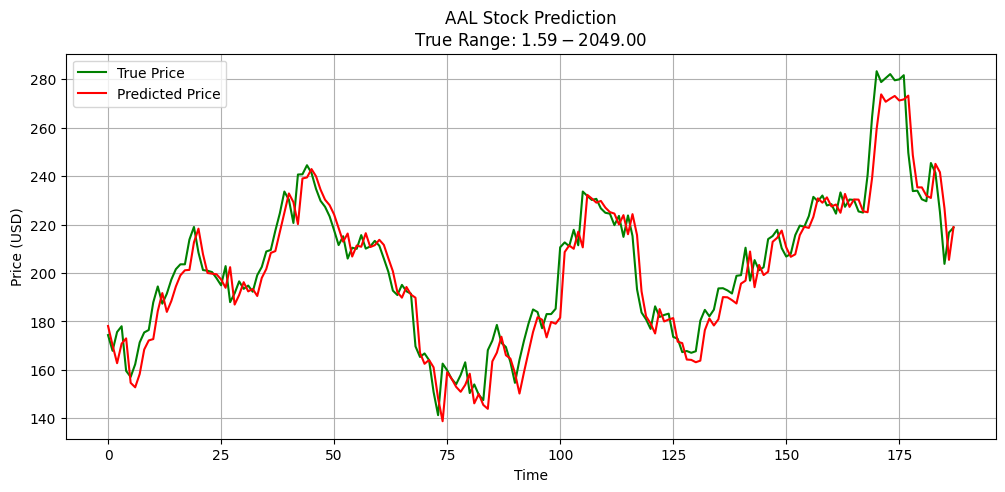


Normalized Metrics:
Test Loss: 0.0247
RMSE: 0.0883
MAE: 0.0665
R²: 0.9092

Denormalized Metrics (USD):
RMSE: $8.83
MAE: $6.65
MAPE: 3.31%


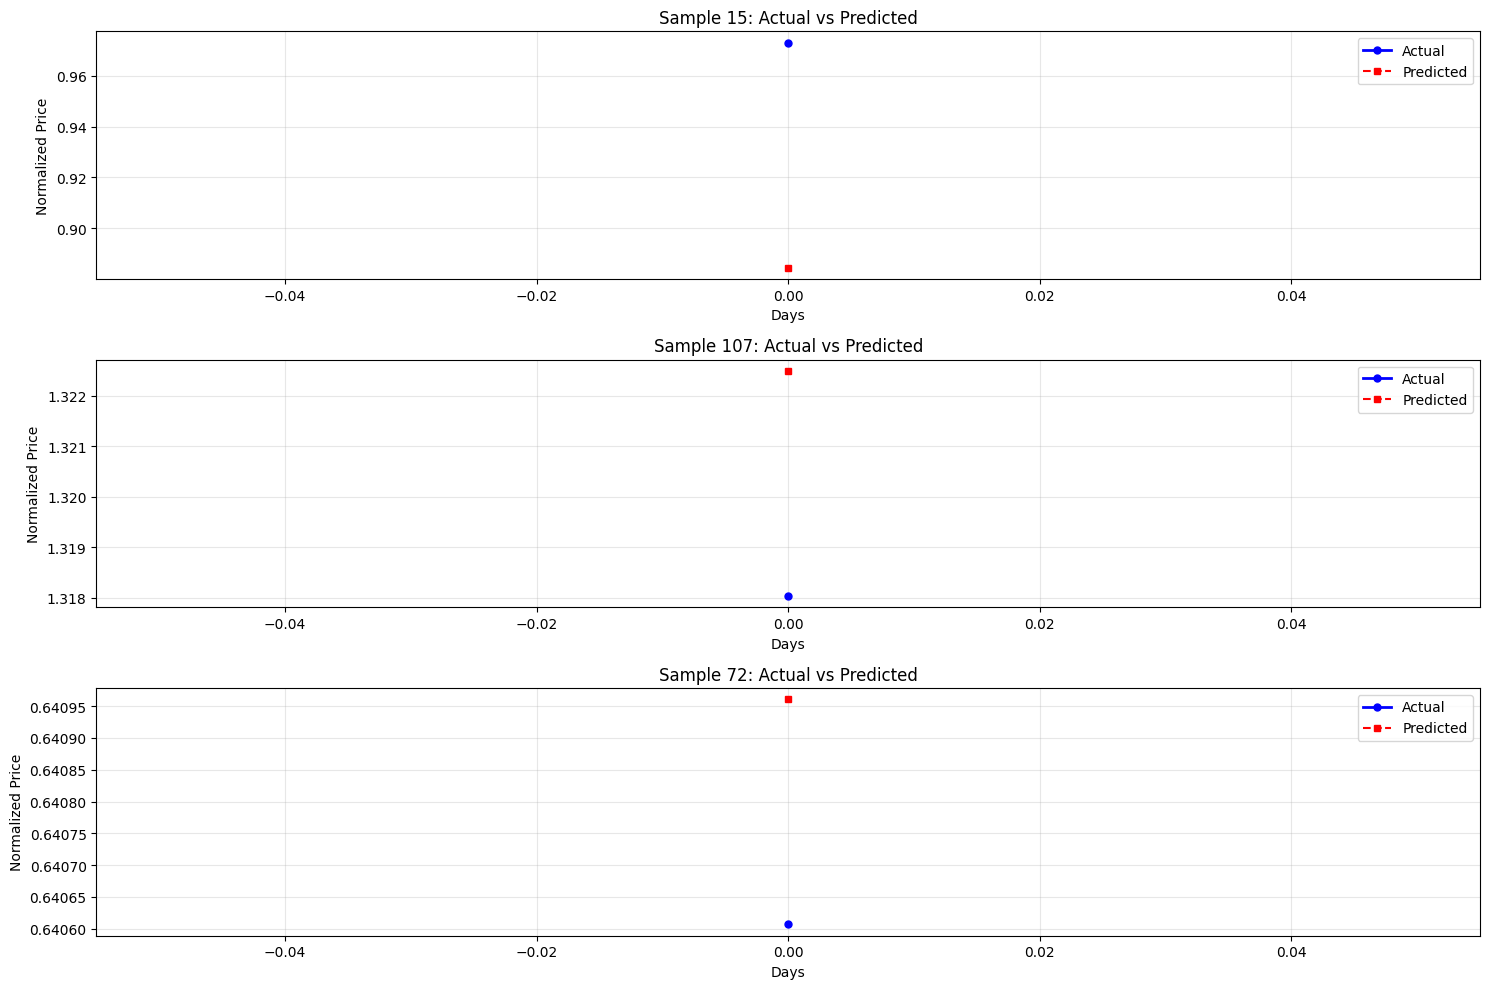

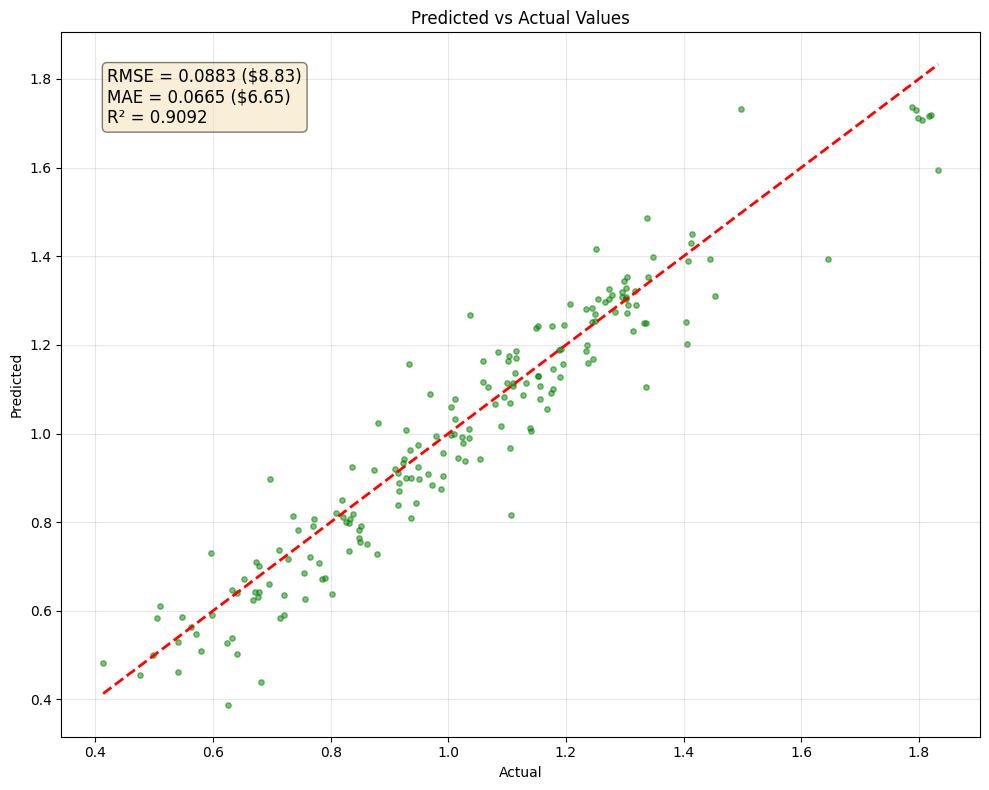

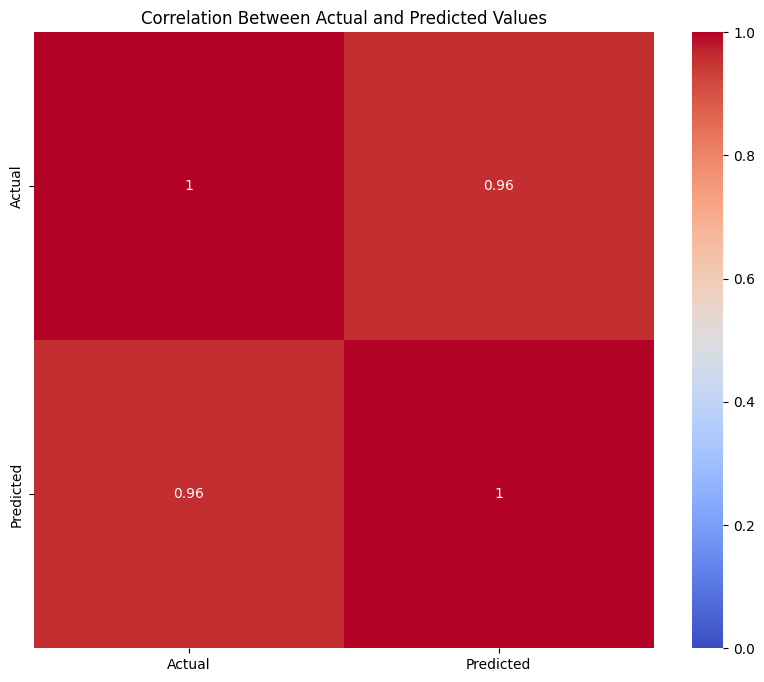

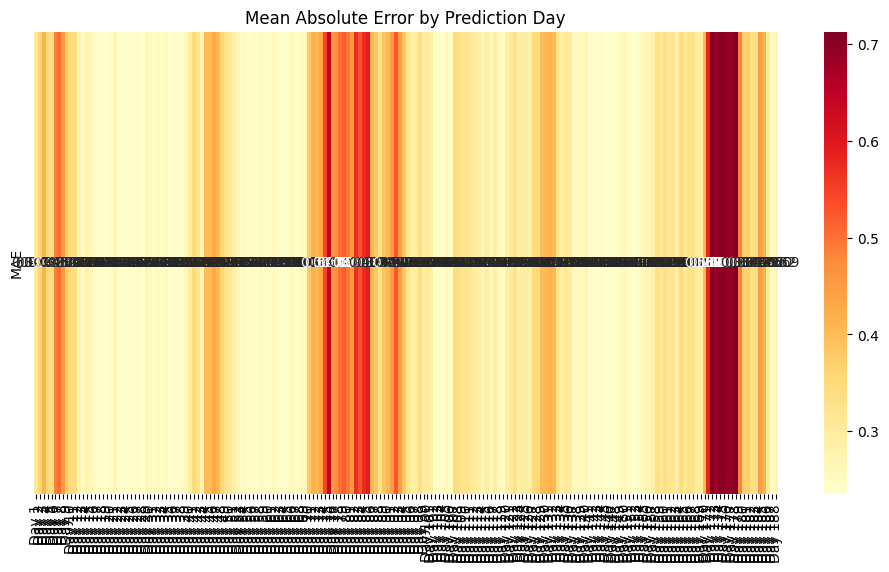

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


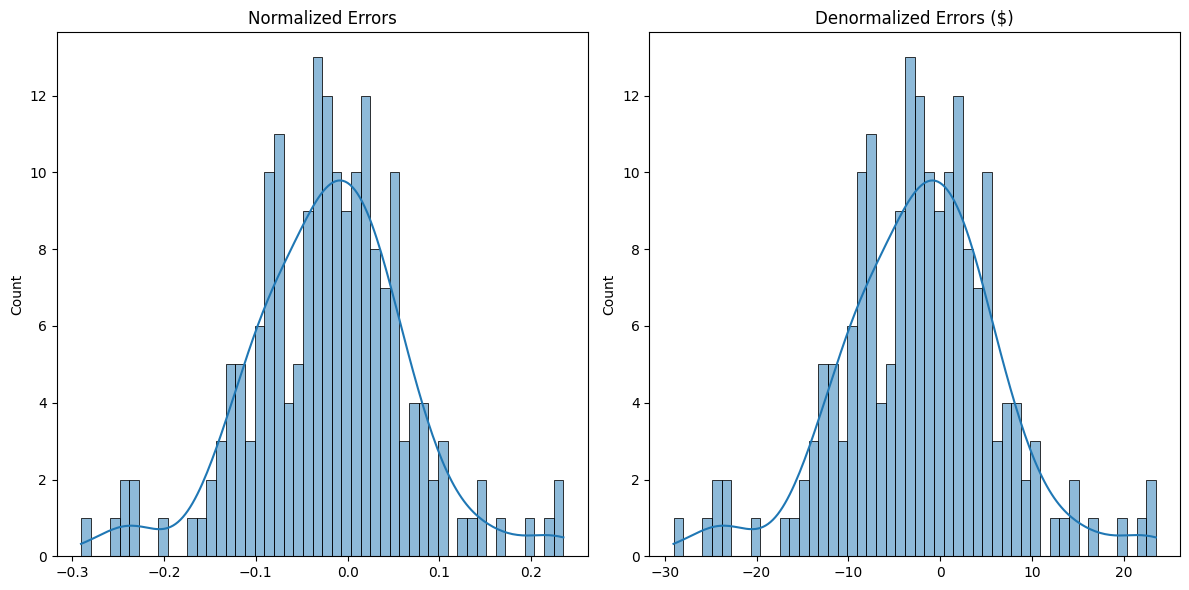

In [353]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tqdm import tqdm
import torch

# Assuming you have your scaler object saved during training
# If not, you'll need to recreate it with the original data range
# Example for MinMaxScaler (adjust if you used StandardScaler):
# scaler = MinMaxScaler()
# scaler.min_, scaler.scale_ = your_saved_min, your_saved_scale

# Define the loss function
criterion = StockLoss(delta=0.5, direction_weight=0.6, margin=0.02)

# Set model to evaluation mode
model.eval()

# Initialize lists to store predictions and ground truth
all_predictions = []
all_ground_truth = []

# Initialize total test loss
total_test_loss = 0

# Disable gradient calculation
with torch.no_grad():
    for i, (x_batch, y_batch) in enumerate(tqdm(test_loader, desc="Testing")):
        # Move data to device
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        
        # Extract the last closing price from input sequence
        last_closing = x_batch[:, -1, 3]  # Shape: [batch_size]
        
        # Create decoder input
        decoder_input = torch.zeros(x_batch.size(0), PRED_LENGTH, 1, device=device)
        decoder_input[:, 0, 0] = last_closing  # Set first time step's feature
        
        # Forward pass
        encoder_output = model['encoder'](x_batch)
        predictions, _ = model['decoder'](decoder_input, encoder_output)
        
        # Calculate loss
        loss = criterion(predictions, y_batch)
        total_test_loss += loss.item() * x_batch.size(0)
        
        # Store predictions and ground truth
        all_predictions.append(predictions.cpu().numpy())
        all_ground_truth.append(y_batch.cpu().numpy())

# Calculate average test loss
avg_test_loss = total_test_loss / len(test_loader.dataset)

# Concatenate all batches
all_predictions = np.concatenate(all_predictions, axis=0)
all_ground_truth = np.concatenate(all_ground_truth, axis=0)

# Flatten for metrics calculation
y_true = all_ground_truth.flatten()
y_pred = all_predictions.flatten()

# Calculate metrics with error handling
try:
    # Normalized metrics
    # Calculate metrics with proper parenthesis balancing
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), 1e-8))) * 100

    # Denormalization example (replace with your actual scaler values)
    data_min = 100.0  # Minimum price in dataset
    data_max = 200.0  # Maximum price in dataset

    y_true_denorm = y_true * (data_max - data_min) + data_min
    y_pred_denorm = y_pred * (data_max - data_min) + data_min
    original_mean = df['close'].mean()
    # Denormalized metrics
    rmse_denorm = np.sqrt(mean_squared_error(y_true_denorm, y_pred_denorm))
    mae_denorm = mean_absolute_error(y_true_denorm, y_pred_denorm)
    mape_denorm = np.mean(np.abs((y_true_denorm - y_pred_denorm) / np.maximum(np.abs(y_true_denorm), 1e-8))) * 100

    # 1. Time-series comparison plot with USD values
    plt.figure(figsize=(12, 5))
    plt.plot(y_true_denorm, label="True Price", color='green')
    plt.plot(y_pred_denorm, label="Predicted Price", color='red')
    plt.title(f"AAL Stock Prediction\nTrue Range: ${df['close'].min():.2f}-${df['close'].max():.2f}")
    plt.xlabel("Time")
    plt.ylabel("Price (USD)")
    plt.legend()
    plt.grid(True)
    plt.show()
    print(f"\nNormalized Metrics:")
    print(f"Test Loss: {avg_test_loss:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")
    
    print(f"\nDenormalized Metrics (USD):")
    print(f"RMSE: ${rmse_denorm:.2f}")
    print(f"MAE: ${mae_denorm:.2f}")
    print(f"MAPE: {mape_denorm:.2f}%")

except Exception as e:
    print(f"Error calculating metrics: {str(e)}")

# Visualization
try:
    # Plot 1: Time-series comparison
    plt.figure(figsize=(15, 10))
    for i in range(3):
        idx = np.random.randint(0, len(all_predictions))
        plt.subplot(3, 1, i+1)
        plt.plot(all_ground_truth[idx], 'b-o', label='Actual', linewidth=2, markersize=5)
        plt.plot(all_predictions[idx], 'r--s', label='Predicted', linewidth=1.5, markersize=5)
        plt.title(f"Sample {idx+1}: Actual vs Predicted")
        plt.xlabel("Days")
        plt.ylabel("Normalized Price")
        plt.grid(alpha=0.3)
        plt.legend()
    plt.tight_layout()
    plt.savefig('time_series_comparison.png', dpi=300)
    plt.show()

    # Plot 2: Scatter plot
    plt.figure(figsize=(10, 8))
    plt.scatter(y_true, y_pred, alpha=0.5, c='green', s=15)
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--', linewidth=2)
    plt.title("Predicted vs Actual Values")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.grid(alpha=0.3)
    
    textstr = '\n'.join((
        f'RMSE = {rmse:.4f} (${rmse_denorm:.2f})',
        f'MAE = {mae:.4f} (${mae_denorm:.2f})',
        f'R² = {r2:.4f}',))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    plt.gca().text(0.05, 0.95, textstr, transform=plt.gca().transAxes,
                  fontsize=12, verticalalignment='top', bbox=props)
    
    plt.tight_layout()
    plt.savefig('scatter_plot.png', dpi=300)
    plt.show()
    # Correlation Heatmap
    plt.figure(figsize=(10, 8))
    correlation_matrix = np.corrcoef(y_true, y_pred)
    sns.heatmap(correlation_matrix, annot=True, 
            xticklabels=['Actual', 'Predicted'], 
            yticklabels=['Actual', 'Predicted'],
            cmap='coolwarm', vmin=0, vmax=1)
    plt.title('Correlation Between Actual and Predicted Values')
    plt.show() 

    # Calculate absolute errors for each prediction day
    abs_errors = np.abs(all_predictions - all_ground_truth)
    mean_errors_by_day = np.mean(abs_errors, axis=0)

    plt.figure(figsize=(12, 6))
    sns.heatmap(mean_errors_by_day.reshape(1, -1), 
            annot=True, fmt=".4f",
            cmap="YlOrRd",
            xticklabels=[f"Day {i+1}" for i in range(mean_errors_by_day.shape[0])],
            yticklabels=['MAE'])
    plt.title('Mean Absolute Error by Prediction Day')
    plt.show() 

    # Plot 3: Error distribution
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    errors_norm = y_pred - y_true
    sns.histplot(errors_norm, kde=True, bins=50)
    plt.title('Normalized Errors')
    
    plt.subplot(1, 2, 2)
    errors_denorm = y_pred_denorm - y_true_denorm
    sns.histplot(errors_denorm, kde=True, bins=50)
    plt.title('Denormalized Errors ($)')
    
    plt.tight_layout()
    plt.savefig('error_distribution.png', dpi=300)
    plt.show()

except Exception as e:
    print(f"Error generating plots: {str(e)}")